In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2


**IMPORTING NECESSARY LIBRARIES**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output

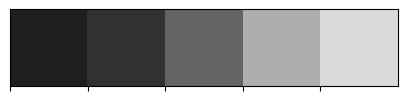

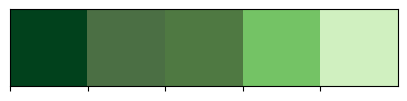

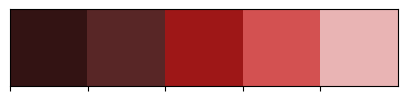

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']
sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)


DATA PREPARATION & PREPROCESSING

In [4]:
X_train = []
Y_train = []
image_size = 224
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for i in labels:
  folderPath = os.path.join('/root/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2','Training',i)
  for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size, image_size))
    X_train.append(img)
    Y_train.append(i)
for i in labels:
  folderPath = os.path.join('/root/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2','Testing',i)
  for j in tqdm(os.listdir(folderPath)):
    img = cv2.imread(os.path.join(folderPath,j))
    img = cv2.resize(img,(image_size,image_size))
    X_train.append(img)
    Y_train.append(i)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|██████████| 74/74 [00:01<00:00, 68.72it/s]


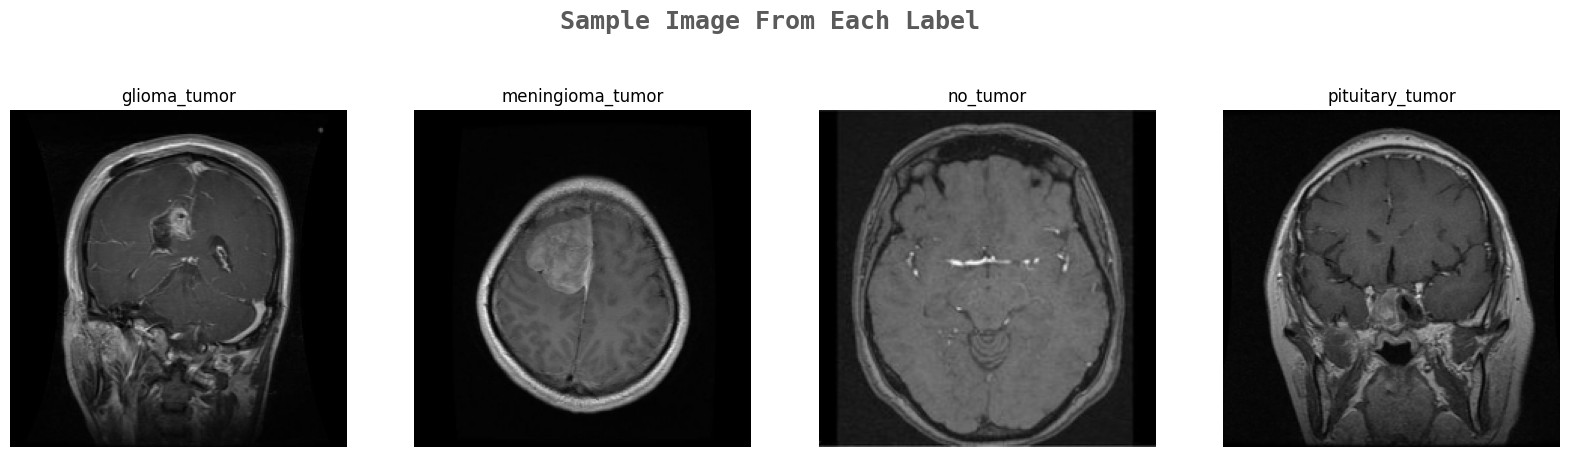

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
  j=0
  while True :
      if Y_train[j]==i:
          ax[k].imshow(X_train[j])
          ax[k].set_title(Y_train[j])
          ax[k].axis('off')
          k+=1
          break
      j+=1

**SHUFFLING & SPLITTING THE DATA INTO TRAINING AND TESTING SETS**


In [6]:
X_train,Y_train = shuffle(X_train,Y_train,random_state=14)
X_train.shape

(3264, 224, 224, 3)

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=14)


**PERFORMING ONE HOT ENCODING :** This helps in converting labes into Numerical
Values

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

**TRANSFER LEARNING**

Deep convolutional neural network models often require a significant amount of time to train,
especially on large datasets. To expedite this process, a common approach is to leverage pre-trained
models that have been developed and fine-tuned on standard computer vision benchmark datasets,
such as the ImageNet image recognition tasks. By reusing the weights from these pre-trained
models, one can benefit from their learned representations and accelerate the training process for their own computer vision problems.
In this notebook, I will utilize the VGG16 model, which comes with pre-trained weights from the
ImageNet dataset. By setting the include_top parameter to False, we exclude the top layer or
output layer of the pre-built model. This allows us to add our own output layer, tailored to our
specific use case.

**VISUAL GEOMETRY GROUP (VGG16) BASE MODEL ARCHITECTURE**

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
# Load VGG16 with pre-trained weights and without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))
# Freeze the VGG16 layers
for layer in base_model.layers:
  layer.trainable = False
# Adding our custom classification layers on top of VGG16

x = base_model.output
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

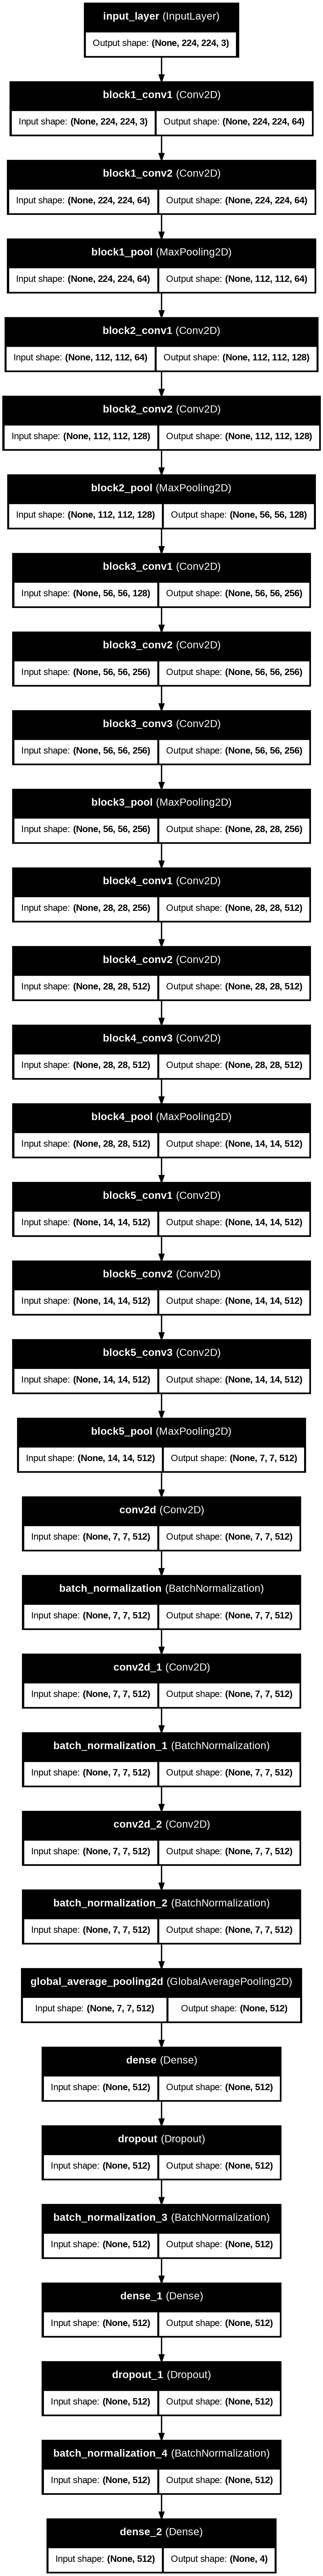

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True,show_layer_names=True)

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models.
They can help you visualize how your model’s training is going, and can even help prevent overfitting
by implementing early stopping or customizing the learning rate on each iteration.

By definition, “A callback is a set of functions to be applied at given stages of the training procedure.
You can use callbacks to get a view on internal states and statistics of the model during training.”

In this notebook, We’ll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau**
callback functions

In [12]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg16.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience= 2, min_delta = 0.001,mode='auto',verbose=1)

In [13]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs =15,verbose=1, batch_size=64,callbacks=[tensorboard,checkpoint,reduce_lr])


Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 42s/step - accuracy: 0.6120 - loss: 1.1034 
Epoch 1: val_accuracy improved from -inf to 0.17591, saving model to vgg16.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1733s 53s/step - accuracy: 0.6148 - loss: 1.0963 - val_accuracy: 0.1759 - val_loss: 23.4279 - learning_rate: 0.0010
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 42s/step - accuracy: 0.8693 - loss: 0.4003 
Epoch 2: val_accuracy improved from 0.17591 to 0.49140, saving model to vgg16.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1753s 52s/step - accuracy: 0.8692 - loss: 0.4006 - val_accuracy: 0.4914 - val_loss: 4.6140 - learning_rate: 0.0010
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.9142 - loss: 0.2586 
Epoch 3: val_accuracy improved from 0.49140 to 0.83174, saving model to vgg16.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1837s 55s/step - accuracy: 0.9142 - loss: 0.2582 - val_accuracy: 0.8317 - val_loss: 0.6896 - learning_rate: 0.0010
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 42s/step - accuracy: 0.9494 

<ipython-input-14-9a79058567fd>:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


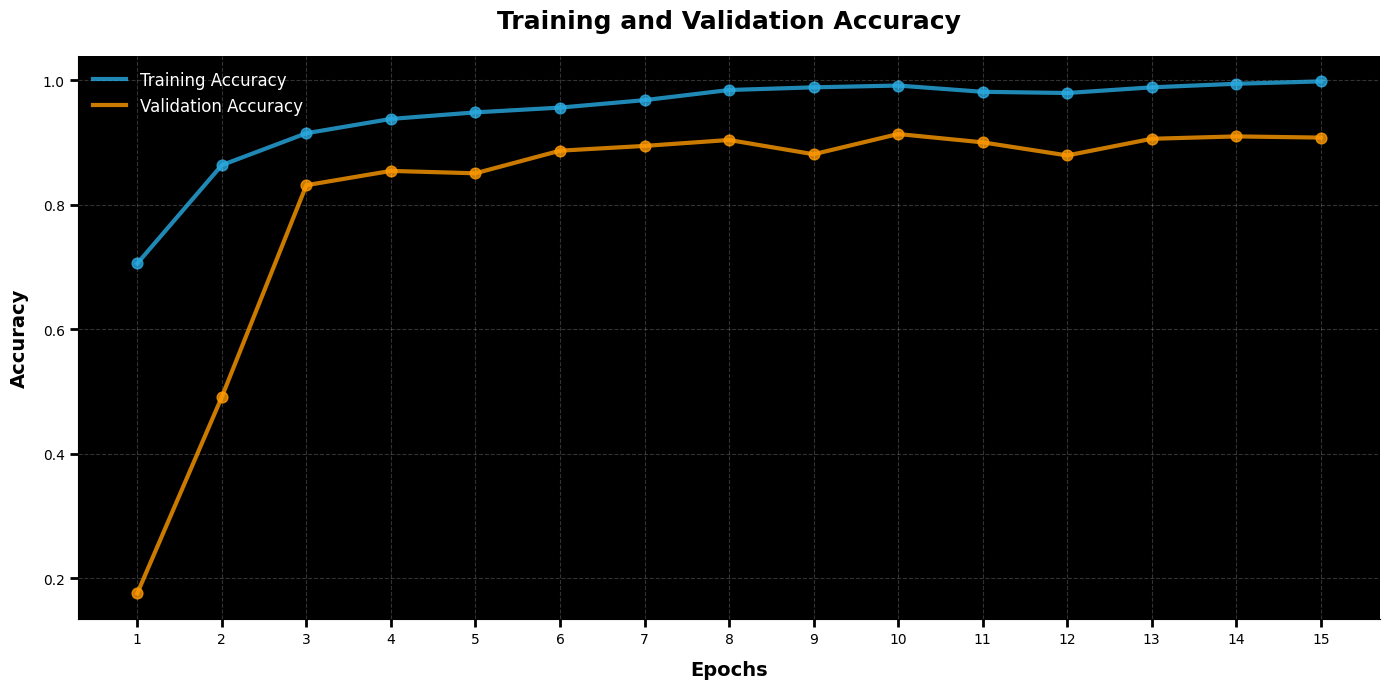

In [14]:
model.save('braintumor.keras')
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='both', length=6, width=2)
ax.set_facecolor('#000000')
ax.plot(epochs, acc, linewidth=3, label="Training Accuracy", color='#29abe2',alpha=0.8)
ax.scatter(epochs, acc, s=60, color='#29abe2', alpha=0.8)
ax.plot(epochs, val_acc, linewidth=3, label="Validation Accuracy",color='#ff9900', alpha=0.8)
ax.scatter(epochs, val_acc, s=60, color='#ff9900', alpha=0.8)
ax.set_xlabel('Epochs', fontsize=14, labelpad=10, color='#000000',fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=14, labelpad=10, color='#000000',fontweight='bold')

ax.set_title('Training and Validation Accuracy', fontsize=18, pad=20,color='#000000', fontweight='bold')
legend = ax.legend(loc='upper left', fontsize=12, frameon=False)
legend.set_title(None)
for handle in legend.legendHandles:
  handle.set_markersize(50)
legend.get_frame().set_facecolor('none')
for text in legend.get_texts():
  text.set_color('#ffffff')
ax.grid(color='#ffffff', linestyle='--', alpha=0.2)
ax.set_xticks(list(epochs))
ax.set_xticklabels(list(epochs))
plt.tight_layout()
plt.show()

<ipython-input-15-d083777755a9>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


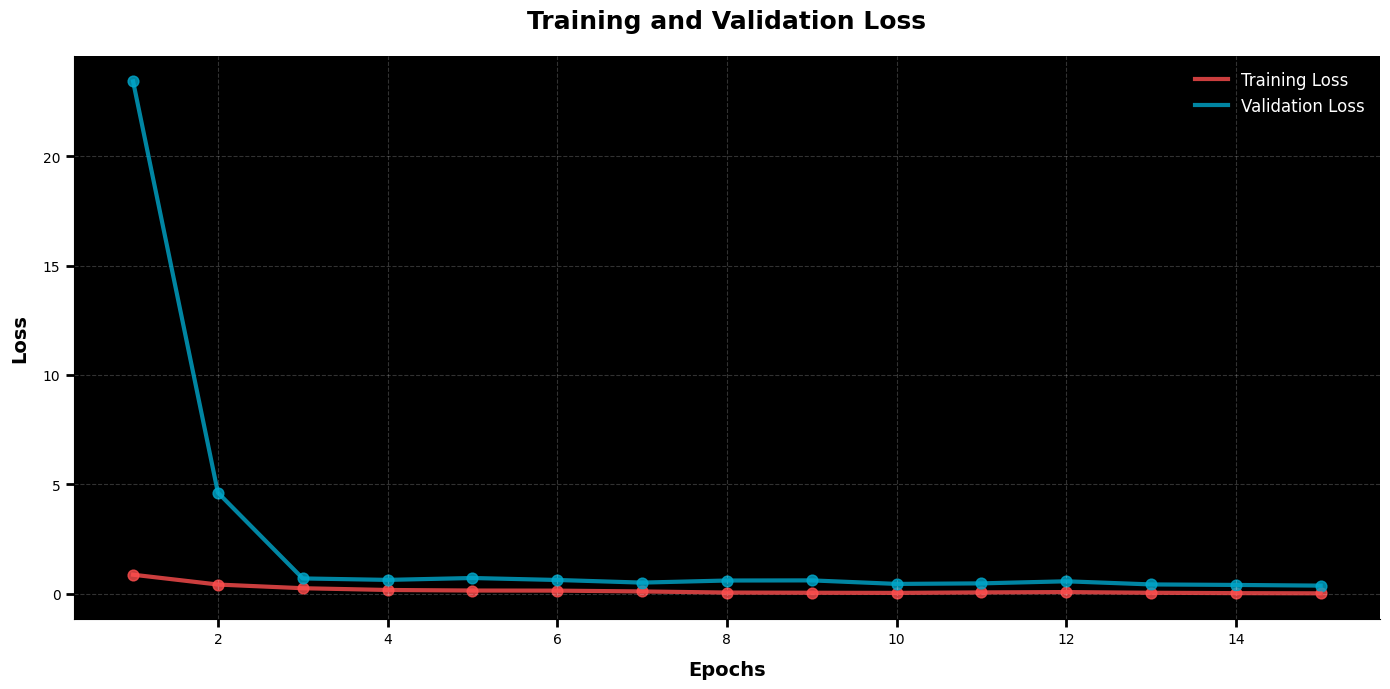

In [15]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='both', which='both', length=6, width=2)
ax.set_facecolor('#000000')
ax.plot(epochs, loss, linewidth=3, label="Training Loss", color='#ff4e4e',alpha=0.8)
ax.scatter(epochs, loss, s=60, color='#ff4e4e', alpha=0.8)
ax.plot(epochs, val_loss, linewidth=3, label="Validation Loss",color='#00a8cc', alpha=0.8)
ax.scatter(epochs, val_loss, s=60, color='#00a8cc', alpha=0.8)
ax.set_xlabel('Epochs', fontsize=14, labelpad=10, color='#000000',fontweight='bold')
ax.set_ylabel('Loss', fontsize=14, labelpad=10, color='#000000',fontweight='bold')
ax.set_title('Training and Validation Loss', fontsize=18, pad=20,color='#000000', fontweight='bold')
legend = ax.legend(loc='upper right', fontsize=12, frameon=False)
legend.set_title(None)
for handle in legend.legendHandles:
  handle.set_markersize(50)
legend.get_frame().set_facecolor('none')
for text in legend.get_texts():
  text.set_color('#ffffff')
ax.grid(color='#ffffff', linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

In [16]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 419s 20s/step


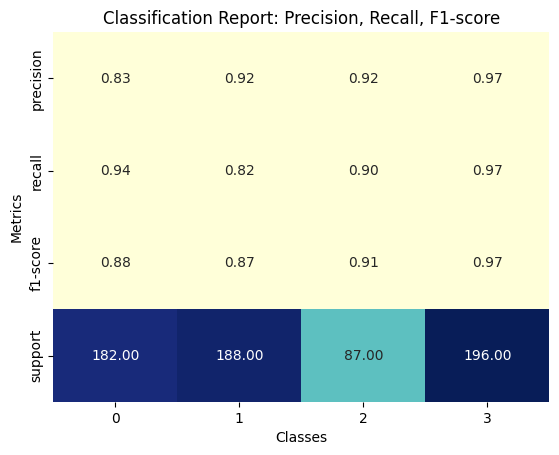

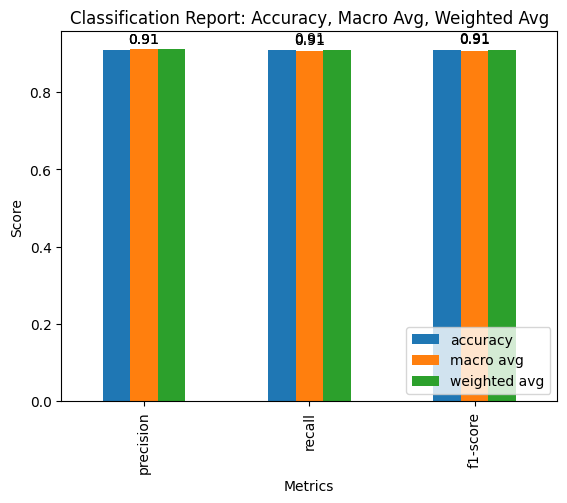

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
# Assuming you have already defined 'y_test_new' and 'pred' variables containing the true labels and predictions.
report = classification_report(y_test_new, pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
sns.heatmap(report_df.iloc[:-3, :].T, annot=True, fmt='.2f', cmap="YlGnBu",cbar=False)
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.title('Classification Report: Precision, Recall, F1-score')
plt.show()
metrics = ['accuracy', 'macro avg', 'weighted avg']
scores = report_df.loc[metrics, ['precision', 'recall', 'f1-score']].T
scores.plot(kind='bar', color=colors)
for i, score in enumerate(scores.values):
  for j, value in enumerate(score):
    plt.text(j, value + 0.01, '{:.2f}'.format(value), ha='center',va='bottom')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Classification Report: Accuracy, Macro Avg, Weighted Avg')
plt.legend(loc='lower right')
plt.subplots_adjust(hspace=0.5)
plt.show()


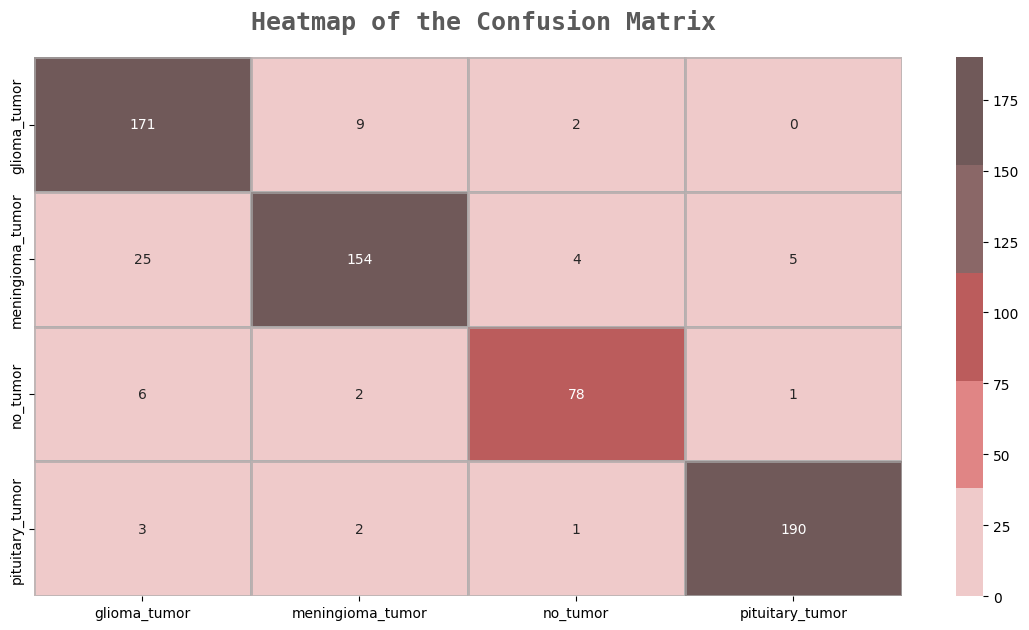

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels,yticklabels=labels, annot=True,
fmt='d', cmap=colors_red[::-1], alpha=0.7, linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)
plt.show()

**Prediction**

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import random
directory_path = '/root/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/2/Testing/'
tumor_classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor','pituitary_tumor']
selected_files_with_labels = {tumor_class: [] for tumor_class in tumor_classes}
num_files_to_select = 3
for tumor_class in tumor_classes:
  class_directory = os.path.join(directory_path, tumor_class)
  class_files = os.listdir(class_directory)
  selected_files = random.sample(class_files, num_files_to_select)
  selected_files_with_labels[tumor_class] = [(file, tumor_class) for file in selected_files]
selected_files_with_labels = [item for sublist in selected_files_with_labels.values() for item in sublist]
image_paths = [os.path.join(directory_path, tumor_class, file) for file,tumor_class in selected_files_with_labels]
class_mapping = {
0: 'Glioma Tumor',
1: 'Meningioma Tumor',
2: 'No Tumor',
3: 'Pituitary Tumor'
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


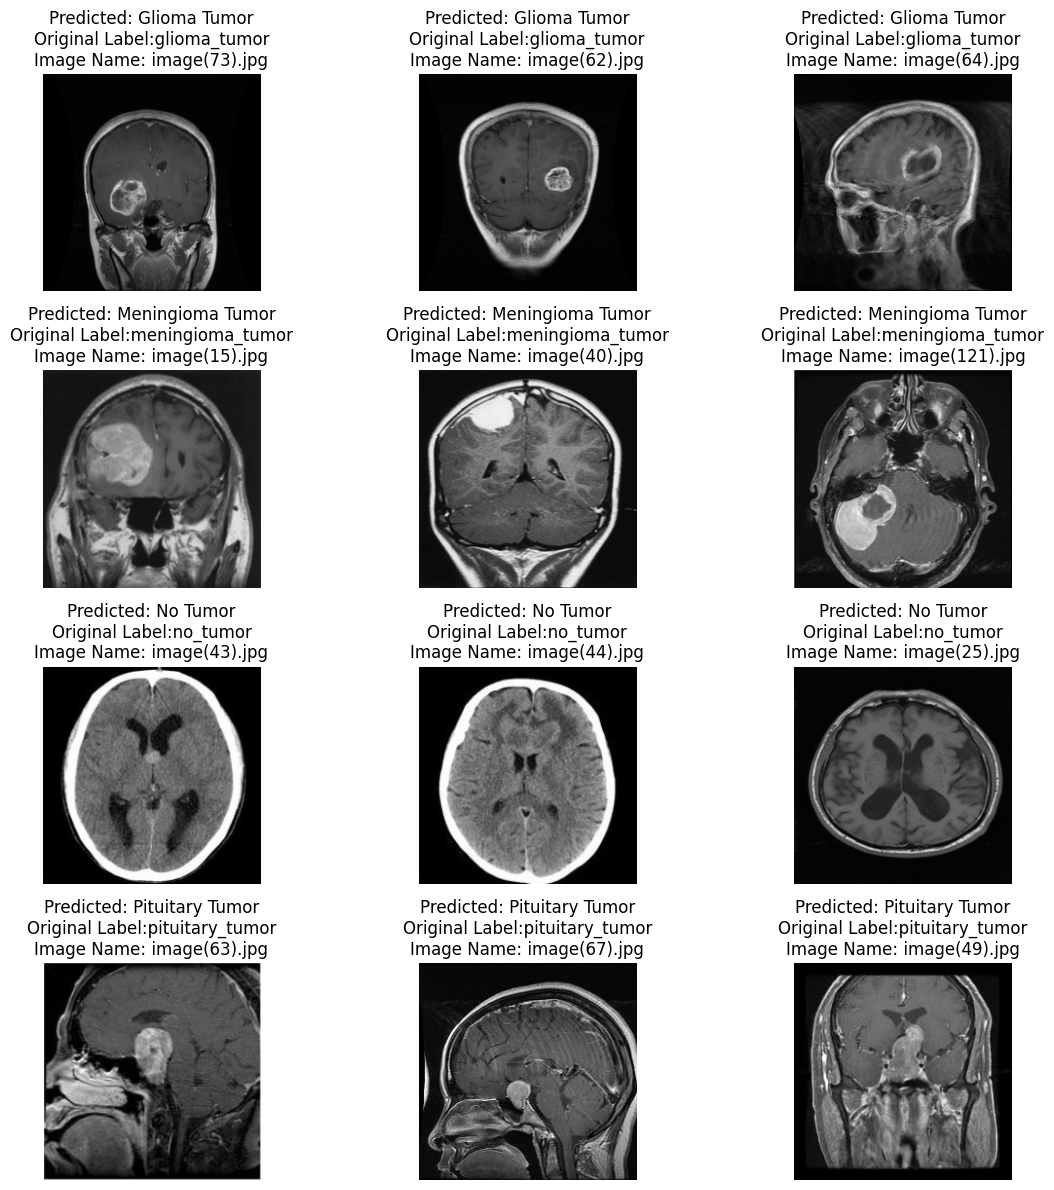

In [20]:
num_images = len(image_paths)
num_rows = int(np.ceil(np.sqrt(num_images)))
num_cols = int(np.ceil(num_images / num_rows))

def shorten_folder_name(folder_name, length=10):
  if len(folder_name) > length:
    return '...' + folder_name[-(length-3):]
  else:
    return folder_name
fig, axes = plt.subplots(4, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.8, wspace=0.8)

class_counters = {class_name: 0 for class_name in class_mapping.values()}

class_images = {class_name: [] for class_name in class_mapping.values()}
class_image_indices = {class_name: [] for class_name in class_mapping.values()}

for i, (path, label) in enumerate(zip(image_paths, selected_files_with_labels)):
  img = cv2.imread(path)
  if img is None:
    print(f"Failed to read image: {path}")
    continue

  img = cv2.resize(img, (224, 224))
  img_array = np.array(img)
  img_array = img_array.reshape(1, 224, 224, 3)
  predictions = model.predict(img_array)
  predicted_class = class_mapping[predictions.argmax()]

  class_images[predicted_class].append(img)
  class_image_indices[predicted_class].append(i)
for i, class_name in enumerate(class_mapping.values()):
  row_images = class_images[class_name]
  row_indices = class_image_indices[class_name]
  num_images = len(row_images)
  for j in range(min(num_images, num_cols)):
      img_index = row_indices[j]
      original_path = image_paths[img_index]
      original_label = selected_files_with_labels[img_index][1]
      axes[i, j].imshow(cv2.cvtColor(row_images[j], cv2.COLOR_BGR2RGB))
      axes[i, j].axis('off')
      axes[i, j].set_title(f"Predicted: {class_name}\nOriginal Label:{original_label}\nImage Name: {os.path.basename(original_path)}") # Use'\n' for a new line
  for j in range(num_images, num_cols):
      fig.delaxes(axes[i, j])

  class_counters[class_name] += num_cols


plt.tight_layout()
plt.show()